## This is an application of a cost function to a confusion matrix, a.k.a a cost matrix.
### Given a cost or savings associated with each of the 4 matrix quadrants tp, tn, fp, fn), we can determine the optimal threshold value 

In [1]:
import sys
sys.path.insert(0, '../shinn')

import find_optimal_thresholds_from_roc_curves as fo
import pandas as pd
import datarobot as dr
import matplotlib.pyplot as plt
%matplotlib inline

from pprint import pprint as pprint

{'_best_value': 13720,
 'accuracy': 0.5575,
 'f1_score': 0.3134212567882079,
 'false_negative_score': 228,
 'false_positive_rate': 0.4755887421022401,
 'false_positive_score': 3312,
 'fraction_predicted_as_negative': 0.485,
 'fraction_predicted_as_positive': 0.515,
 'lift_negative': 1.0812603255623916,
 'lift_positive': 1.5144131648986017,
 'matthews_correlation_coefficient': 0.2044538609399211,
 'model_id': '5c9e483385804658b1324e6c',
 'model_name': 'eXtreme Gradient Boosted Trees Classifier with Early Stopping and Unsupervised Learning Features',
 'negative_predictive_value': 0.9412371134020618,
 'positive_predictive_value': 0.19611650485436893,
 'project_id': '5c9e44115ff3774aec083eea',
 'threshold': 0.11753588914871216,
 'true_negative_rate': 0.5244112578977599,
 'true_negative_score': 3652,
 'true_positive_rate': 0.7799227799227799,
 'true_positive_score': 808}

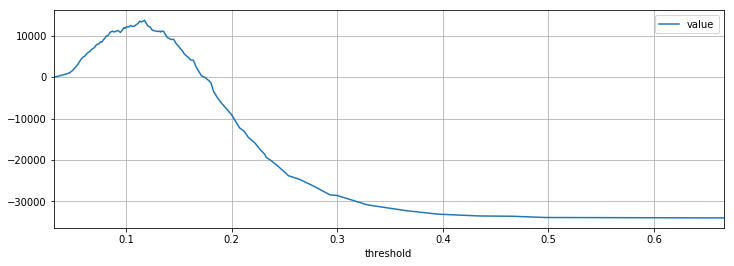

In [2]:
#
# The non-functional programming version of David Shinn's code
# 
# project = dr.Project.get('5c706f7f114a6d305a75e34c')
project = dr.Project.get('5c9e44115ff3774aec083eea')

def find_optimal_threshold(tn, fn, tp, fp, model, source, objective_label='objective', maximize=True):

    def payoff_function(roc_point):
        tns = roc_point['true_negative_score']
        fns = roc_point['false_negative_score']
        tps = roc_point['true_positive_score']
        fps = roc_point['false_positive_score']
        return tn*tns + fn*fns + tp*tps + fp*fps

    # dict to return, holds all values we want to see/output
    output_values = {'project_id': model.project_id,  
                     'model_id': model.id,
                     'model_name': model.model_type,
                     objective_label: None}
    
    # Get the roc points for the source partition we want:
    # - validation', 'crossValidation', or 'holdout'
    for roc_curve in model.get_all_roc_curves():
        if roc_curve.source == source:
            break
    else: # source not found
        print('source not found:', output_values)
        return output_values

    # initialize the current best value to the first roc point
    best_index = 0
    best_value = payoff_function(roc_curve.roc_points[0])

    points = []
    # update best_value as the cost value improves
    for current_index, roc_point in enumerate(roc_curve.roc_points[1:], 1):
        current_value = payoff_function(roc_point)
        if maximize:
            if current_value > best_value:
                best_value = current_value
                best_index = current_index
        else:
            if current_value < best_value:
                best_value = current_value
                best_index = current_index
                
        # Append the roc point threshold and value to a list
        point = {}
        point['idx'] = current_index
        point['threshold'] = roc_point['threshold']
        point['value'] = current_value
        points.append(point)
        
    output_values.update(roc_curve.roc_points[best_index])
    output_values[objective_label] = best_value
    
    # Plot the payoff value as a function of threshold
    points_df = pd.DataFrame(points)
    points_df.plot(x='threshold', y='value', figsize=(12,4), grid=True)
    
    return output_values

model = project.get_models()[0]
objective_label = '_best_value'
source = 'crossValidation'  

# Lending Club example, where TN is worth 10 of interest and a FN is worth -100 of principal lost. 
# TP and FP have no effect since we’re not capturing opportunity costs.
find_optimal_threshold(tn=10, fn=-100, tp=0, fp=0,
                       model=model, source=source, objective_label=objective_label, maximize=True)

In [3]:
# 
# David's single model cost matrix optimize
# 
threshold = fo.find_optimal_threshold(model=project.get_models()[0],
                                        objective_function=fo.create_payoff_function(tn=10, fn=-100, tp=0, fp=0), 
                                        objective_label='payoff', source='crossValidation', maximize=True)
threshold

{'accuracy': 0.5575,
 'f1_score': 0.3134212567882079,
 'false_negative_score': 228,
 'false_positive_rate': 0.4755887421022401,
 'false_positive_score': 3312,
 'fraction_predicted_as_negative': 0.485,
 'fraction_predicted_as_positive': 0.515,
 'lift_negative': 1.0812603255623916,
 'lift_positive': 1.5144131648986017,
 'matthews_correlation_coefficient': 0.2044538609399211,
 'model_id': '5c9e483385804658b1324e6c',
 'negative_predictive_value': 0.9412371134020618,
 'payoff': 13720,
 'positive_predictive_value': 0.19611650485436893,
 'project_id': '5c9e44115ff3774aec083eea',
 'threshold': 0.11753588914871216,
 'true_negative_rate': 0.5244112578977599,
 'true_negative_score': 3652,
 'true_positive_rate': 0.7799227799227799,
 'true_positive_score': 808}

In [4]:
# 
# David's all models cost matrix optimize
# 
thresholds = fo.find_optimal_thresholds(project=project, 
                                        objective_function=fo.create_payoff_function(tn=10, fn=-100, tp=0, fp=0), 
                                        objective_label='payoff', source='crossValidation', maximize=True)
thresholds

[{'accuracy': 0.5575,
  'f1_score': 0.3134212567882079,
  'false_negative_score': 228,
  'false_positive_rate': 0.4755887421022401,
  'false_positive_score': 3312,
  'fraction_predicted_as_negative': 0.485,
  'fraction_predicted_as_positive': 0.515,
  'lift_negative': 1.0812603255623916,
  'lift_positive': 1.5144131648986017,
  'matthews_correlation_coefficient': 0.2044538609399211,
  'model_id': '5c9e483385804658b1324e6c',
  'negative_predictive_value': 0.9412371134020618,
  'payoff': 13720,
  'positive_predictive_value': 0.19611650485436893,
  'project_id': '5c9e44115ff3774aec083eea',
  'threshold': 0.11753588914871216,
  'true_negative_rate': 0.5244112578977599,
  'true_negative_score': 3652,
  'true_positive_rate': 0.7799227799227799,
  'true_positive_score': 808},
 {'accuracy': 0.521375,
  'f1_score': 0.30140485312899107,
  'false_negative_score': 210,
  'false_positive_rate': 0.5196726019529007,
  'false_positive_score': 3619,
  'fraction_predicted_as_negative': 0.444374999999999